# Diplomatura Universitaria en Inteligencia Artificial
## Trabajo Práctico del Módulo de Aprendizaje Automático 

Relizado en conjunto:
[Nuria Sarochar](https://www.linkedin.com/in/nuria-sarochar/)
y
[Damián Cravacuore](https://www.linkedin.com/in/cravacuore/).

Junio 2020.

# Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Análisis exploratorio de datos

## Lectura de dato

Importamos dataset de [Insurance](https://www.kaggle.com/mirichoi0218/insurance).

In [ ]:
csv_file_url='https://drive.google.com/uc?id=18ya0mOAjks3wNVPh8_MZUw4qp_-hyoCx'
original_data = pd.read_csv(csv_file_url)

data = original_data.copy()
print(data.head())
data.describe()

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Visualizamos la estructura del dataset, y sus características estadísticas generales.

## Observamos si hay datos faltantes

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Observando la información dada sobre el dataset, vemos que no hay datos faltantes en ninguna columna.

## Separamos nuestra data de nuestro target (clase)

In [ ]:
y = data['charges']
X = data.drop(columns='charges')

## Calculamos matriz de correlación

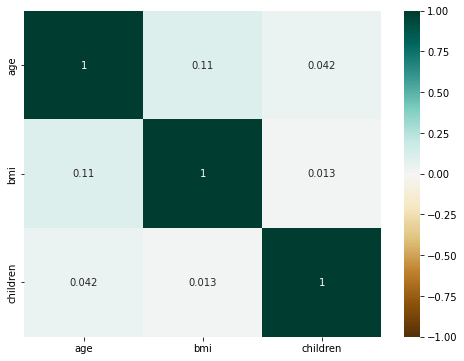

In [ ]:
plt.figure(figsize=(8,6));
sns.heatmap(X.corr(), vmin=-1.0, vmax=1.0, center=0.0, annot=True, cmap='BrBG');

Calculamos esta matriz para saber la correlación entre las variables numéricas. Y podemos observar que no hay correlación significativa.

## Scatter plot + histograms

Visualizamos el comportamiento de las variables numéricas entre ellas y la distribución de sus valores.

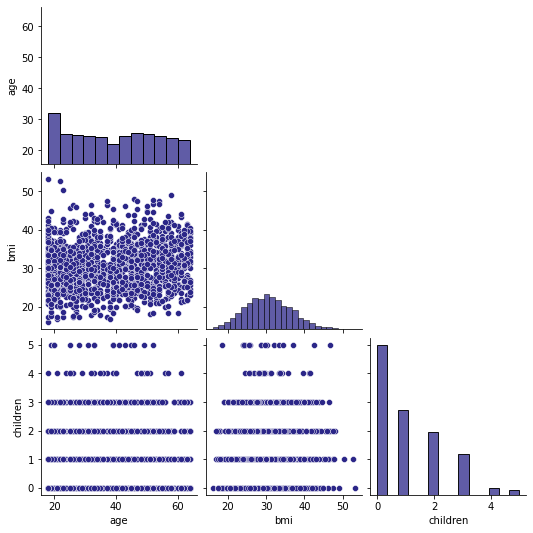

In [ ]:
sns.set_palette("CMRmap")

# Función para ocultar la diagonal superior
def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)
    
eucalyptus_plot = sns.pairplot(X)
eucalyptus_plot.map_upper(hide_current_axis)
plt.show()

Vemos que la distribuciones de edades tiene un pico para los más jóvenes (20 años) mientras que el resto es bastante parejo. Para el 'bmi' se puede observar una distribución gausseana, con una media en 30 confirmando lo que se observó anteriormente de las estadísticas del dataset. Con respecto a los hijos hay mayor cantidad de asegurados que no tienen hijos y para los que sí tienen hijos la relación es inversamente proporcional entre la cantidad de hijos y la cantidad de asegurados.

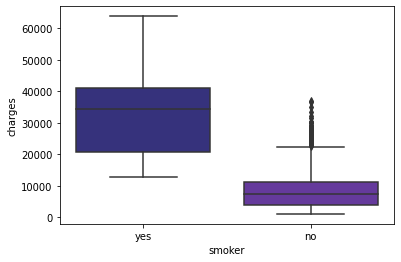

In [ ]:
sns.boxplot(data = data, x = 'smoker', y = 'charges')

Graficamos la distribución de 'charges' sobre fumadores y no fumadores. Podemos visualizar que para los fumadores la media y los percentiles del 75 y 25 son mucho mayores que para los no fumadores y por lo tanto los costos son mayores. Además para los no fumadores vemos una gran cantidad de *outliers*.

# Primer Modelo

## Preprocesamiento

Vemos las distintas categorías para nuestras columnas feature categóricas.

In [ ]:
print(X['region'].unique())
print(X['smoker'].unique())
print(X['sex'].unique())

['southwest' 'southeast' 'northwest' 'northeast']
['yes' 'no']
['female' 'male']


Convertimos las variables categóricas a dummies.

In [ ]:
X = pd.get_dummies(X, prefix=['is', 'smoker'], columns=['sex', 'smoker'], drop_first=True)
X = pd.get_dummies(X, prefix=['from'], columns=['region'])
X = X.rename(columns={'smoker_yes': 'is_smoker'})
X

,age,bmi,children,is_male,is_smoker,from_northeast,from_northwest,from_southeast,from_southwest
0,19,27.900,0,0,1,0,0,0,1
1,18,33.770,1,1,0,0,0,1,0
2,28,33.000,3,1,0,0,0,1,0
3,33,22.705,0,1,0,0,1,0,0
4,32,28.880,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,1,0,0,1,0,0
1334,18,31.920,0,0,0,1,0,0,0
1335,18,36.850,0,0,0,0,0,1,0
1336,21,25.800,0,0,0,0,0,0,1


### Particionado de datos para modelo

In [ ]:
# sacamos el 30% de las muestras para los datos de test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
# y repetimos ahora, pero sacando un 10% para los datos de validación
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, random_state=10)
# verificamos sus tamaños
print('Training set size: {}'.format(X_train.shape))
print('Validation set size: {}'.format(X_val.shape))
print('Test set size: {}'.format(X_test.shape))

Training set size: (842, 9)
Validation set size: (94, 9)
Test set size: (402, 9)


Hacemos una estandarización de los datos teniendo en cuenta la media y el desvío estándar. Luego de esta transformación la media será cero (0) y el desvío estándar será uno (1).

In [ ]:
ct = ColumnTransformer([('transformer', StandardScaler(), ['age','bmi','children'])], remainder = 'passthrough')
ct.fit(X_train)

X_train = ct.transform(X_train)
X_val = ct.transform(X_val)
X_test = ct.transform(X_test)

## Modelado

### Funciones auxiliares

In [ ]:
# Definimos función para realizar el fit con el randomizedSearch y obtener los
# mejores hiperparámetros para el modelo.
def cv_fit_get_best_and_rmse(cv, X_train, y_train, X_val, y_val):
  cv.fit(X_train, y_train)
  cv_best = cv.best_estimator_
  y_pred = cv_best.predict(X_val)
  RMSE = np.sqrt(mean_squared_error(y_pred, y_val))
  return cv_best, cv.best_params_, RMSE

def draw_feature_importance_graph(X, cv_best):
  plt.bar(X.columns, cv_best.feature_importances_)
  plt.xticks(ticks=np.arange(X.columns.size), labels=X.columns, rotation=90)
  plt.title('Feature importance')
  plt.xlabel('Features')
  plt.ylabel('Feature importance')
  plt.grid(True)
  plt.show()

def print_params_and_rmse(params, rmse):
  print("Mejores hiperparámetros: {}".format(params))
  print("RMSE del mejor modelo sobre conjunto de validación: {} \n".format(rmse))

### Regresor lineal

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

RMSE = np.sqrt(mean_squared_error(y_pred, y_val))
print("RMSE de regresor lineal sobre conjunto de validación: {}".format(RMSE))

RMSE de regresor lineal sobre conjunto de validación: 5764.451546922193


### Regresor Ridge

In [ ]:
ridge = Ridge() # fit_intercept=True, normalize=False es por dafault
params = {'alpha': [0.0001, 0.01, 1.0, 10.0, 100.0, 10000]}
ridge_cv = RandomizedSearchCV(ridge, params, cv= 5, n_iter=6)

ridge_best, ridge_best_params, ridge_rmse = cv_fit_get_best_and_rmse(ridge_cv, X_train, y_train, X_val, y_val)
print_params_and_rmse(ridge_best_params, ridge_rmse)

Mejores hiperparámetros: {'alpha': 1.0}
RMSE del mejor modelo sobre conjunto de validación: 5767.25744258812 



## Test

In [ ]:
y_pred = ridge_best.predict(X_test)
RMSE = np.sqrt(mean_squared_error(y_pred, y_test))
print("RMSE del mejor modelo sobre conjunto de testeo: {}".format(RMSE))

RMSE del mejor modelo sobre conjunto de testeo: 6077.99633328123


## Conclusión de este modelo

Viendo el resultado utilizando el modelo de Ridge, nos da un error medio cuadrático de 6077.99, lo que quiere decir, que nuestro modelo le está errando por una gran cantidad de dólares para un seguro anual, por lo tanto vamos a cambiar el preprocesamiento para intentar mejorar el modelo.

# Segundo Modelo

## Preprocesamiento

Hacemos una nueva copia del dataset y lo dividimos extrayendo la columna de clases.

In [ ]:
data2 = original_data.copy()

y = data2['charges']
X = data2.drop(columns='charges')

Hacemos un get dummies con las columnas sex y smoker, y para la de regiones las mapeamos de 1 a 4. De esta forma no tenemos categorías divididas en varias columnas de One Hot Encoding y podemos probar con algoritmos basados en árboles.

In [ ]:
X = pd.get_dummies(X, prefix=['is', 'smoker'], columns=['sex', 'smoker'], drop_first=True)
X = X.rename(columns={'smoker_yes': 'is_smoker'})

regions_mapping = {
  'southwest': 1,
  'southeast': 2,
  'northwest': 3,
  'northeast': 4
}
X['region'] = X['region'].map(regions_mapping)
X

,age,bmi,children,region,is_male,is_smoker
0,19,27.900,0,1,0,1
1,18,33.770,1,2,1,0
2,28,33.000,3,2,1,0
3,33,22.705,0,3,1,0
4,32,28.880,0,3,1,0
...,...,...,...,...,...,...
1333,50,30.970,3,3,1,0
1334,18,31.920,0,4,0,0
1335,18,36.850,0,2,0,0
1336,21,25.800,0,1,0,0


### Particionado de datos para modelo

In [ ]:
# sacamos el 30% de las muestras para los datos de test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
# y repetimos ahora, pero sacando un 10% para los datos de validación
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, random_state=10)
# verificamos sus tamaños
print('Training set size: {}'.format(X_train.shape))
print('Validation set size: {}'.format(X_val.shape))
print('Test set size: {}'.format(X_test.shape))

Training set size: (842, 6)
Validation set size: (94, 6)
Test set size: (402, 6)


Hacemos una estandarización de los datos teniendo en cuenta la media y el desvío estándar. Luego de esta transformación la media será cero (0) y el desvío estándar será uno (1).

In [ ]:
ct = ColumnTransformer([('transformer', StandardScaler(), ['age','bmi','children'])], remainder = 'passthrough')
ct.fit(X_train)

X_train = ct.transform(X_train)
X_val = ct.transform(X_val)
X_test = ct.transform(X_test)

## Modelado

### Regresor lineal

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

RMSE = np.sqrt(mean_squared_error(y_pred, y_val))
print("RMSE de regresor lineal sobre conjunto de validación: {}".format(RMSE))

RMSE de regresor lineal sobre conjunto de validación: 5773.82117766183


### Regresor Ridge

In [ ]:
ridge = Ridge() # fit_intercept=True, normalize=False es por dafault
params = {'alpha': [0.0001, 0.01, 1.0, 10.0, 100.0, 10000]}
ridge_cv = RandomizedSearchCV(ridge, params, cv= 5, n_iter=6)

ridge_best, ridge_best_params, ridge_rmse = cv_fit_get_best_and_rmse(ridge_cv, X_train, y_train, X_val, y_val)
print_params_and_rmse(ridge_best_params, ridge_rmse)

Mejores hiperparámetros: {'alpha': 1.0}
RMSE del mejor modelo sobre conjunto de validación: 5767.25744258812 



### Regresor Random Forest

Mejores hiperparámetros: {'n_estimators': 1000}
RMSE del mejor modelo sobre conjunto de validación: 3767.968000680312 



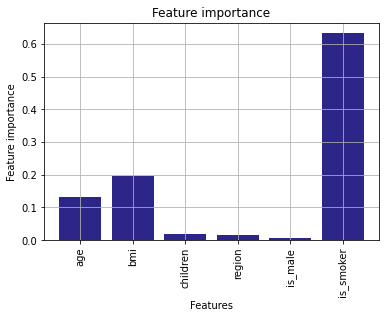

In [ ]:
rf = RandomForestRegressor()
params = {'n_estimators': [50, 100, 200, 300, 400, 500, 1000]}
rf_cv = RandomizedSearchCV(rf, params, cv= 5, n_iter=7)

rf_best, rf_best_params, rf_rmse = cv_fit_get_best_and_rmse(rf_cv, X_train, y_train, X_val, y_val)
print_params_and_rmse(rf_best_params, rf_rmse)
draw_feature_importance_graph(X, rf_best)

### Regresor Gradient Boosting

Mejores hiperparámetros: {'n_estimators': 50}
RMSE del mejor modelo sobre conjunto de validación: 3275.8936311645134 



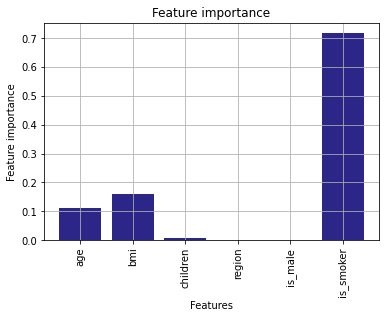

In [ ]:
gbt = GradientBoostingRegressor()
params = {'n_estimators': [10, 50, 100, 200, 300]}
gbt_cv = RandomizedSearchCV(gbt, params, cv = 5, n_iter=5)

gbt_best, gbt_best_params, gbt_rmse = cv_fit_get_best_and_rmse(gbt_cv, X_train, y_train, X_val, y_val)
print_params_and_rmse(gbt_best_params, gbt_rmse)
draw_feature_importance_graph(X, gbt_best)

## Test

In [ ]:
y_pred = gbt_best.predict(X_test)
RMSE = np.sqrt(mean_squared_error(y_pred, y_test))
print("RMSE del mejor modelo sobre conjunto de testeo: {}".format(RMSE))

RMSE del mejor modelo sobre conjunto de testeo: 4394.273817072628


# Conclusión general

Se hicieron dos preprocesamientos distintos, esperando mejoras para el segundo modelo. En el segundo modelo al no haber encodeado las variables categoricas en dummies, solo las que eran de dos categorías, fue posible aplicar árboles algoritmos basados en árboles. Esto mostró una gran mejora en el modelo. El mejor modelo fue al entrenar con Gradient Boosted Trees, obteniendo un RMSE total de 4394.27. De todos modos, este sigue siendo un número elevado.